In [208]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import numpy as np
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from math import ceil
%matplotlib notebook

Data_Path = 'Data_Footprints_2018-06-12.csv'
Data = pd.read_csv(Data_Path)
Data = Data.set_index(pd.DatetimeIndex(Data.datetime))
Data = Data.drop('datetime',axis=1)
# print(Data['PPFD_Avg'])

# Data = Data.interpolate().bfill()
# Data = Data.interpolate().ffill()

Data['fch4']*=1000
aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD',
        'AirTC_Avg':'T$_{a}$','Out_of_Basin':'F$_{out}$',
        'Sedge':'F$_{sdg}$','air_pressure':'P$_{a}$',
        'Shrub':'F$_{shb}$','Sparse':'F$_{spr}$','Grass':'F$_{grs}$'
         ,'Temp':'T$_{s}$','H':'$H$','VPD':'$VPD$','VWC':'$VWC$'}
def Read(var,aliases):
    Filling_Path = 'GapFilled'+var+'.csv'
    Filling = pd.read_csv(Filling_Path)
    Filling = Filling.set_index(pd.DatetimeIndex(Filling.datetime))
    Summary_Path = 'GapFillingSummary'+var+'.csv'
    Runs = pd.read_csv(Summary_Path).drop('Unnamed: 0',axis=1)
    print(Runs.head())
    Runs['Name']=''
    Runs['Foundation']=''
    Group = Runs.groupby('Key').agg({'Model': 'first', 'Foundation': 'first','Name': 'first', 
                                    'Level': 'first','MSE': 'mean', 'R2': 'mean'})
    Group['SE'] = Runs[['Key','MSE']].groupby('Key').sem()
    Group = Group.reset_index()
#     print(Group['MSE'].sem())
#     Group['SE'] = Runs[['Key','MSE']].groupby('Key').sem()
    Runs.loc[Runs['Level']==0,'Best'] = 'Best'    
    Levels = Group.groupby('Level').min()
    Sub=Group[Group['MSE'].isin(Levels['MSE'].values)]
    Sub.sort_values('Level',inplace=True)
    Sub = Sub.loc[Sub['Level']>=1]
    for level in Sub['Level']:
        if level != 1:
            a  = Sub.loc[Sub['Level']==level-1,'Model'].values[0].split('+')
            for i,row in Group.loc[Group['Level']==level].iterrows():
#                 try:
                b = row['Model'].split('+')
#                 print(a,b,level,[c for c in b if c not in a][0])
                Group.loc[((Group['Model'] == row['Model']) & (Group['Level']==level)),'Name']\
                = aliases[[c for c in b if c not in a][0]]
                Group.loc[Group['Level']==level,'Foundation']=Sub.loc[Sub['Level']==level-1,'Model'].values[0]
#                 except:
#                     print(row['Model'])
#                     Group.loc[Group['Model']==row['Model'],'Name']=row['Model']
#                     pass
        else:
            for i,row in Group.loc[Group['Level']==level].iterrows():
                Group.loc[Group['Model']==row['Model'],'Name']=aliases[row['Model']]
    
    return(Filling,Runs,Group)
fco2_fill,fco2_Runs,fco2_summary = Read('fco2',aliases)
fch4_fill,fch4_Runs,fch4_summary = Read('fch4',aliases)



Colors ={}
Colors['fco2']=[0,1,0]
Colors['fch4']=[1,0,0]
    
sizes = (6.5,6.5)
# print(Data)
# print(fco2_summary.loc[])

   Key  Level       MSE                               Model        R2
0  5_0  5      1.177396  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.867170
1  5_0  5      1.146856  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.882642
2  5_0  5      1.119343  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.873719
3  5_0  5      1.069996  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.890507
4  1_0  1      1.218766  PPFD_Avg                            0.862503


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   Key  Level         MSE                               Model        R2
0  5_0  5      58.541215   PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.634611
1  5_0  5      42.468487   PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.666926
2  5_0  5      57.700480   PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.639859
3  5_0  5      51.034873   PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.599742
4  1_0  1      156.928759  PPFD_Avg                            0.020519


# Performance at Level 1

Loaded model from disk


<IPython.core.display.Javascript object>


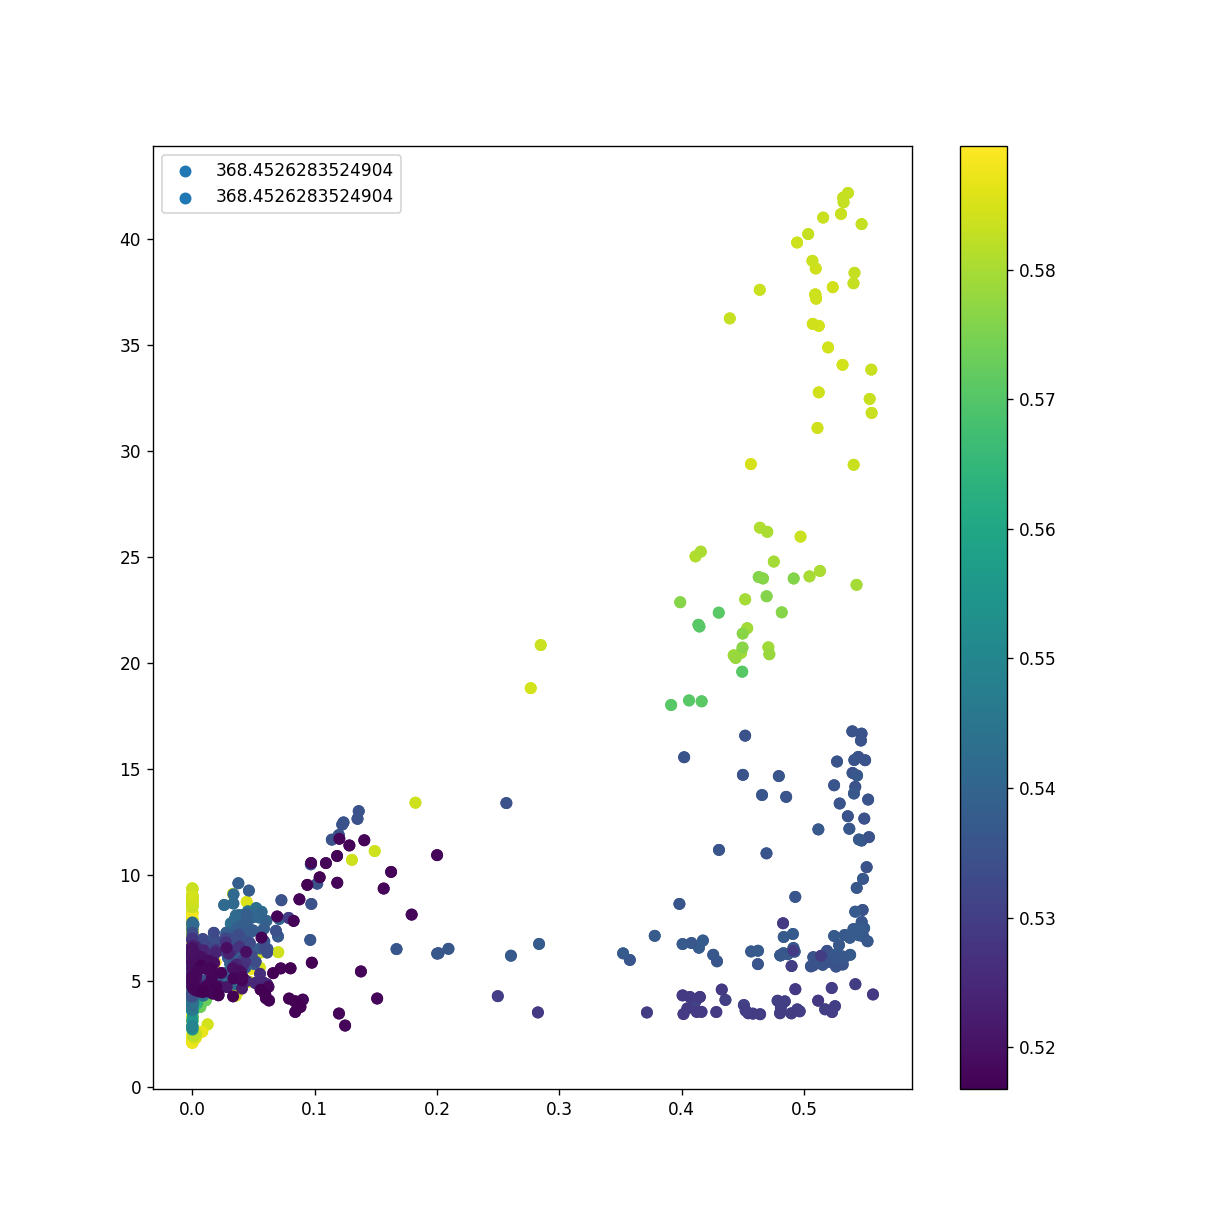

['PPFD_Avg', 'Sedge', 'VWC']
 32/870 [>.............................] - ETA: 1s0.5426535299454612


In [217]:
from keras.models import model_from_json

import ReadStandardTimeFill as RSTF
json_file = open('C:/Users/wesle/ML_GapFilling/Weights/model0.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/Users/wesle/ML_GapFilling/Weights/0_0.h5")
print("Loaded model from disk")


plt.figure(figsize=(10,10))
FullModel = fch4_summary.loc[fch4_summary['Level']==0,'Model'].values[0].split('+')
# FullModel = 'PPFD_Avg+AirTC_Avg+VWC'
print(FullModel)
for i in range(2):
    RST = RSTF.ReadStandardTimeFill('Data_Footprints_2018-06-12.csv')
    RST.Scale('fch4',FullModel)
    y = RST.y*1.0
    X = RST.X*1.0
#     if i == 0:
#         X[:,0]=X[:,0].min()
#     if i == 1:
#         X[:,0]=X[:,0].mean()
#     if i == 2:
#         X[:,0]=X[:,0].max()
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')#loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    score = loaded_model.evaluate(X, y, verbose=1)
    rest = loaded_model.predict(X)
    rest = RST.YScaled.inverse_transform(rest.reshape(-1,1))
    X = RST.XScaled.inverse_transform(X)
    print(score)
    plt.scatter(X[:,1],rest,label=X[:,0].mean(),c=X[:,2])
plt.colorbar()
plt.legend()


<IPython.core.display.Javascript object>


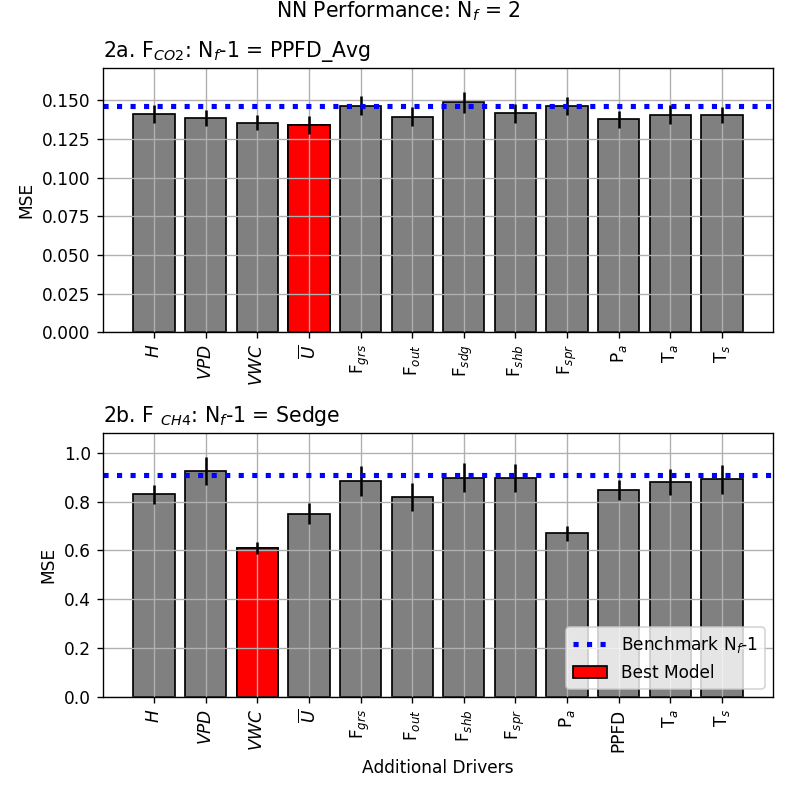

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [195]:
fig,ax = plt.subplots(2,1,figsize=sizes)
def Level_Plot(ax,l,Summary,title,yl,Score='MSE'):
    Sub = Summary.loc[Summary['Level']==l]
    if l == 1:
        ax.bar(Sub['Name'],Sub[Score],yerr=Sub['SE'],facecolor='grey',edgecolor='black')
    else:
        ax.bar(Sub['Name'],Sub[Score],yerr=Sub['SE'],facecolor='grey',edgecolor='black')
#     print(Sub[['Name',Score,'Model']])
    ax.grid()
    ax.set_ylabel('MSE')
    plt.sca(ax)
    plt.xticks(rotation=90)
    ax.set_ylim(0,yl)
    if Score =='MSE':
        Parsimony = Sub.loc[Sub[Score] == Sub[Score].min()]
    else:
        Parsimony = Sub.loc[Sub[Score] == Sub[Score].max()]
    ax.bar(Parsimony['Name'],Parsimony[Score],facecolor='red',edgecolor='black',label = 'Best Model')
    yl = Sub[Score].max()+Sub['SE'].max()
    ax.set_ylim(0,yl+yl*.1)
    ax.set_title(title,loc='left')
    if l >1:
        y = Summary.loc[Summary['Model']==Parsimony['Foundation'].values[0],Score].values
        xl = ax.get_xlim()
        ax.set_xlim(xl[0],xl[1])
        ax.plot([xl[0],xl[1]],[y,y],linestyle = ':',color = 'blue',linewidth=3,label = 'Benchmark N$_f$-1')
        ax.set_title(title+': N$_f$-1 = '+Sub['Foundation'].values[0].replace('+',' & '),loc='left')
#     print(Sub.loc[Sub[Score]<=(Parsimony[Score].values[0]+Parsimony['SE'].values[0])])
    Sub['T'] = Sub[Score]-(Parsimony[Score].min()+Parsimony['SE'].max())
#     print(Sub['T'])

Fignum = '2'
Level = 2
Level_Plot(ax[0],Level,fco2_summary,Fignum+'a. F$_{CO2}$',1.12,Score ='MSE')
Level_Plot(ax[1],Level,fch4_summary,Fignum+'b. F $_{CH4}$',1.12,Score ='MSE')
plt.sca(ax[0])
plt.suptitle('NN Performance: N$_f$ = '+str(Level),x=.5,y=1)
if Level == 1:
    ax[1].set_xlabel('Drivers')
else:
    ax[1].set_xlabel('Additional Drivers')
ax[1].legend(loc=4)

# plt.tight_layout()
plt.tight_layout(rect=[0, 0.0, 1, 0.97])
plt.savefig('Fig'+Fignum+'.png')

# Best performer at each factor level

<IPython.core.display.Javascript object>


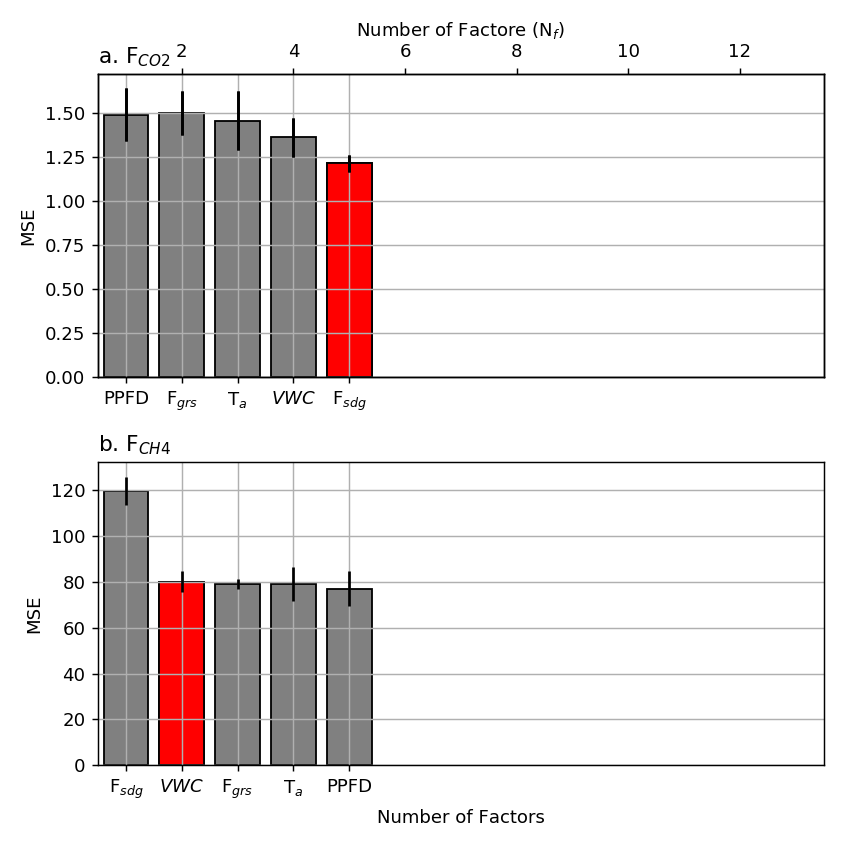

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


     Key                               Model                    Foundation  \
0   0_21  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass                                 
1   1_0   PPFD_Avg                                                           
2   1_1   AirTC_Avg                                                          
3   1_2   Sedge                                                              
4   1_3   VWC                                                                
5   1_4   Grass                                                              
6   2_0   PPFD_Avg+AirTC_Avg                  PPFD_Avg                       
7   2_1   PPFD_Avg+Sedge                      PPFD_Avg                       
8   2_2   PPFD_Avg+VWC                        PPFD_Avg                       
9   2_3   PPFD_Avg+Grass                      PPFD_Avg                       
10  3_0   PPFD_Avg+AirTC_Avg+Grass            PPFD_Avg+Grass                 
11  3_1   PPFD_Avg+Sedge+Grass                PPFD_Avg+Grass    

In [66]:
fig,ax = plt.subplots(2,1,figsize=sizes)
def Bars(ax,Summary,title,Score):
    if Score == 'MSE':
        Levels = Summary.groupby('Level').min()
    else:
        Levels = Summary.groupby('Level').max()
    Sub=Summary[Summary[Score].isin(Levels[Score].values)]#[['Model',
#                                     'STD',Score,'CI','Level','SE']]
    Sub.sort_values('Level',inplace=True)
    Sub = Sub.loc[Sub['Level']>=1]
    Sub.reset_index(inplace=True,drop=True)
        
    ax.bar(Sub['Level'],Sub[Score],yerr = Sub['SE'],facecolor='grey',edgecolor='black')
    ax.set_ylabel('MSE')
  
    MinMod = Sub[Sub[Score] == Sub[Score].min()]
    Sub['Sig']=False
    # ID'd using 1SE rule
    Parsimony = Sub.loc[Sub['Model']==Summary.loc[Summary['Level']==0,'Model'].values[0]]
    ax.bar(Parsimony['Level'],Parsimony[Score],facecolor='red',edgecolor='black')
    if title == 'a. F$_{CO2}$':
        yaxy = ax.twiny()
        yaxy.bar(Sub['Level'],Sub[Score],yerr = Sub['SE'],facecolor='None',edgecolor='None')
        yaxy.bar(Parsimony['Level'],Parsimony[Score],facecolor='None',edgecolor='None')
        yaxy.set_xlim(.5,13.5)
        yaxy.set_xlabel('Number of Factore (N$_f$)')
    plt.sca(ax)
    plt.xticks(Sub['Level'].values,Sub['Name'].values)
    ax.set_title(title,loc='left')
    ax.set_xlim(.5,13.5)
    ax.grid()
    
# plt.suptitle('Best Performing Models')
ax[1].set_xlabel('Number of Factors')
Bars(ax[0],fco2_summary,'a. F$_{CO2}$',Score='MSE')
Bars(ax[1],fch4_summary,'b. F$_{CH4}$',Score='MSE')
plt.tight_layout()#rect=[0, 0.0, 1, 0.97])
plt.savefig('Fig3.png')
# Sub
print(fco2_summary)
# print(fch4_summary)

<IPython.core.display.Javascript object>


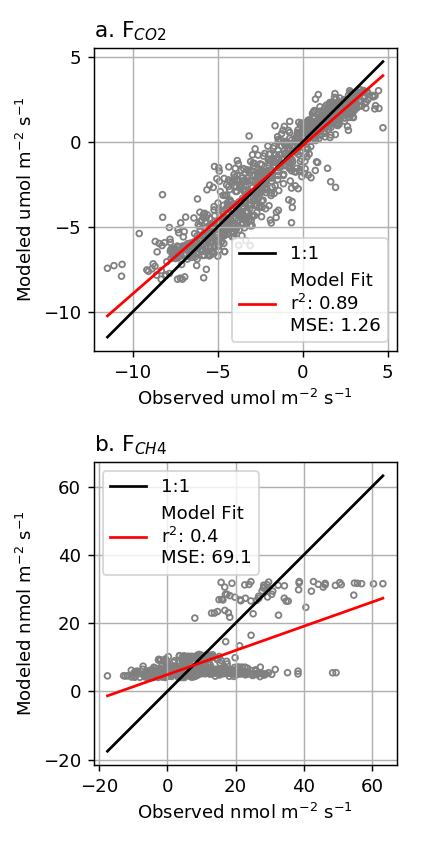

-0.21757528926345038 0.8723196211021637
[-15. -10.  -5.   0.   5.  10.] [-15. -10.  -5.   0.   5.  10.]
4.886636494352115 0.35436694929571555
[-40. -20.   0.  20.  40.  60.  80.] [-40. -20.   0.  20.  40.  60.  80.]


In [67]:

def Full(summary,Data,Fill,var,ax,title):
    ax.locator_params(nbins=5)
    ax.set(aspect='equal')
    if var == 'fch4':
        Units = 'nmol m$^{-2}$ s$^{-1}$'
    else:
        Units = 'umol m$^{-2}$ s$^{-1}$'
    mod = summary.loc[summary['Level']==0,'Model'].values[0]
#     print(summary.loc[summary['Level']==0])
    Data['Fill']=Fill['BestModel: '+mod]
    Temp = Data[[var,'Fill']].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(Temp[var],Temp['Fill'])
    MSE = metrics.mean_squared_error(Temp[var],Temp['Fill'])
    print(intercept,slope)
    ax.scatter(Temp[var],Temp['Fill'],facecolor='None',edgecolor='grey',marker='o',label=None,s=10)
    Line = np.linspace(Temp[var].min(),Temp[var].max(),10)
    ax.plot(Line,Line,color='black',label = '1:1')
    ax.plot(Line,Line*slope+intercept,color='red',label = 'Model Fit\nr$^2$: '+str(np.round(r_value**2,2))\
                                                              +'\nMSE: '+str(np.round(MSE,2)))
    ax.grid()
    ax.legend()
    ax.set_title(title,loc='left')
    ax.set_ylabel('Modeled '+ Units)
    ax.set_xlabel('Observed '+ Units)
    
#     ax.set_xticks(ax.get_yticks())
#     ax.set_yticks(ax.get_xticks())
    print(ax.get_yticks(),ax.get_xticks())
    
fig,ax=plt.subplots(2,1,figsize=(3.25,6.5))
Full(fco2_summary,Data,fco2_fill,'fco2',ax[0],'a. F$_{CO2}$')
Full(fch4_summary,Data,fch4_fill,'fch4',ax[1],'b. F$_{CH4}$')
plt.tight_layout()


<IPython.core.display.Javascript object>


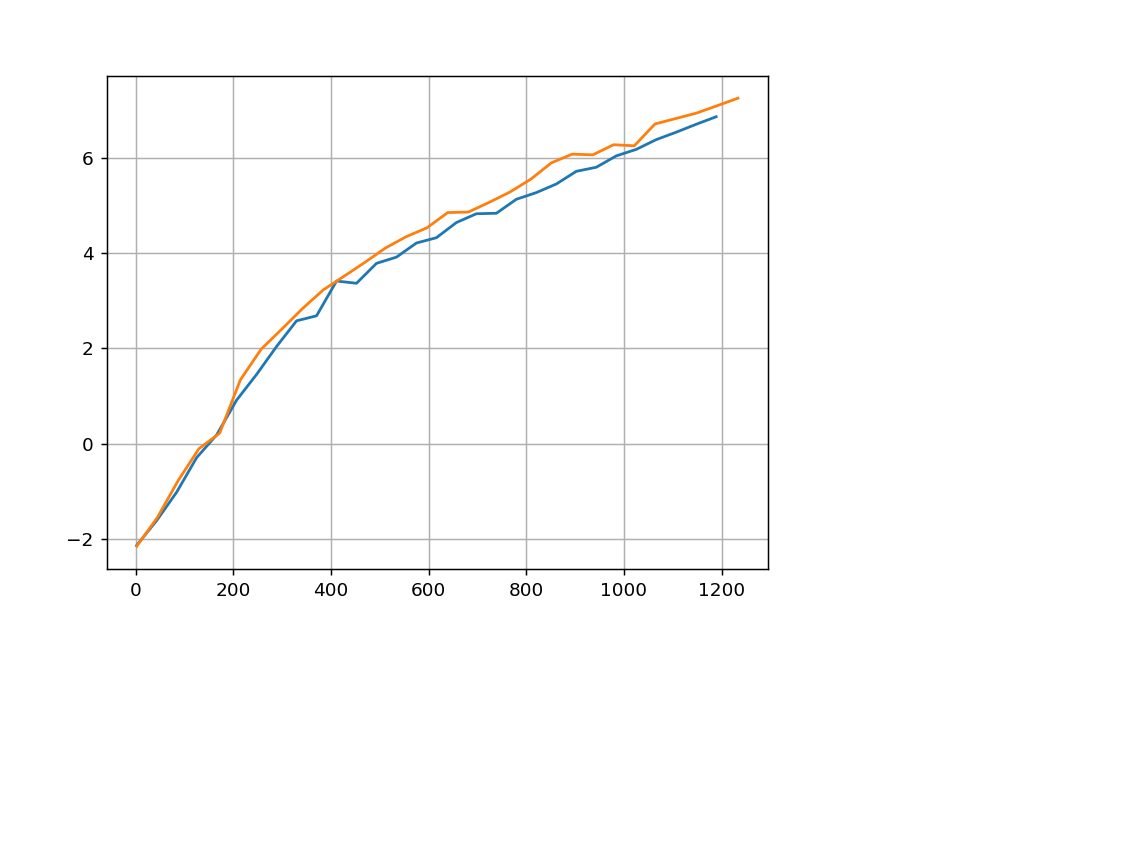

<IPython.core.display.Javascript object>


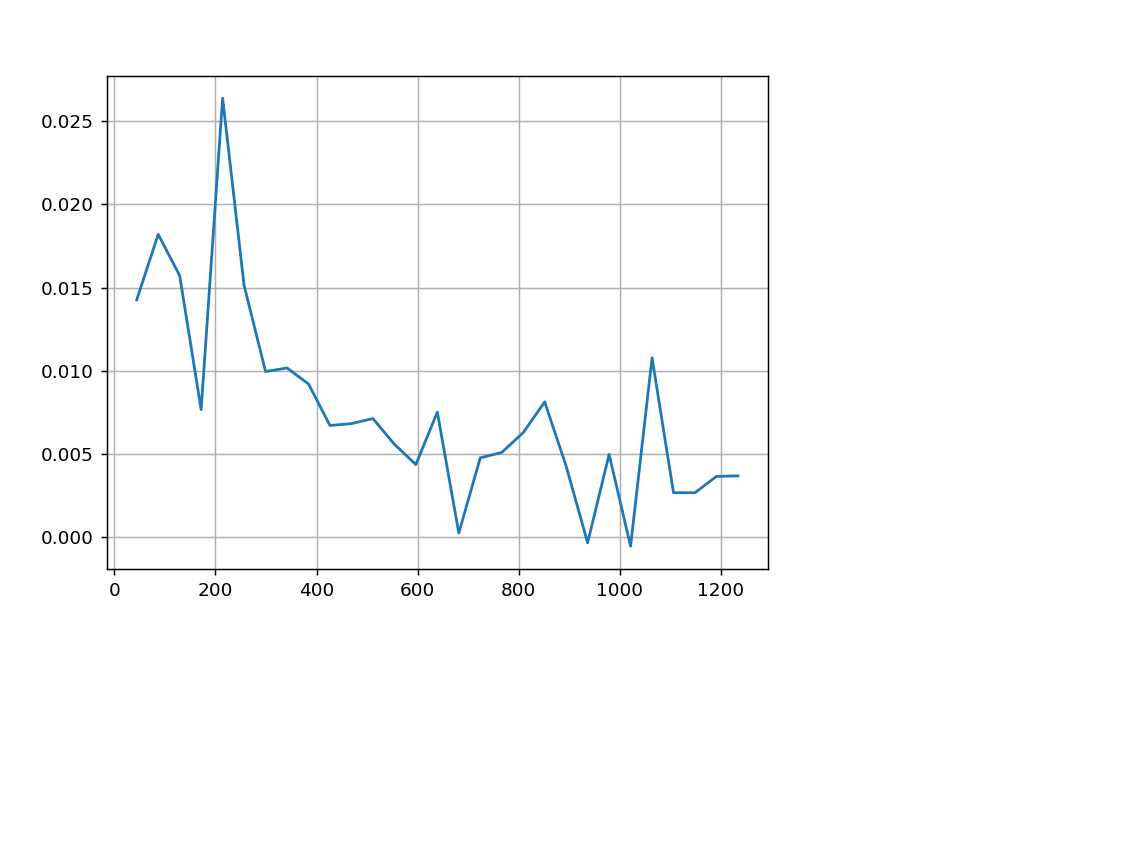

In [191]:

from scipy.interpolate import griddata
Model = 'PPFD_Avg+Grass'
Data['Fill'] = fco2_fill['Model: '+Model]*-1
Temp = Data[['Grass','PPFD_Avg','Fill']].dropna(axis=0).sort_values('PPFD_Avg')
Temphi = Temp.loc[Temp['Grass']>Temp['Grass'].mean()]
Templo = Temp.loc[Temp['Grass']<=Temp['Grass'].mean()]
x=Temphi['PPFD_Avg'].values
Response = Temphi['Fill'].values
N=30
xi = np.arange(x.min(),x.max(),(x.max()-x.min())/N)
ri = griddata((x),Response,(xi),method='linear')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xi,ri)
# plt.grid()

x=Templo['PPFD_Avg'].values
Response = Templo['Fill'].values
xi = np.arange(x.min(),x.max(),(x.max()-x.min())/N)
ri = griddata((x),Response,(xi),method='linear')
ax.plot(xi,ri)
ax.grid()

fig = plt.figure()
ax = fig.add_subplot(111)
offset = 1
Dif = np.diff(ri,offset)/np.diff(xi,offset)
plt.plot(xi[offset:],Dif)
plt.grid()


<IPython.core.display.Javascript object>


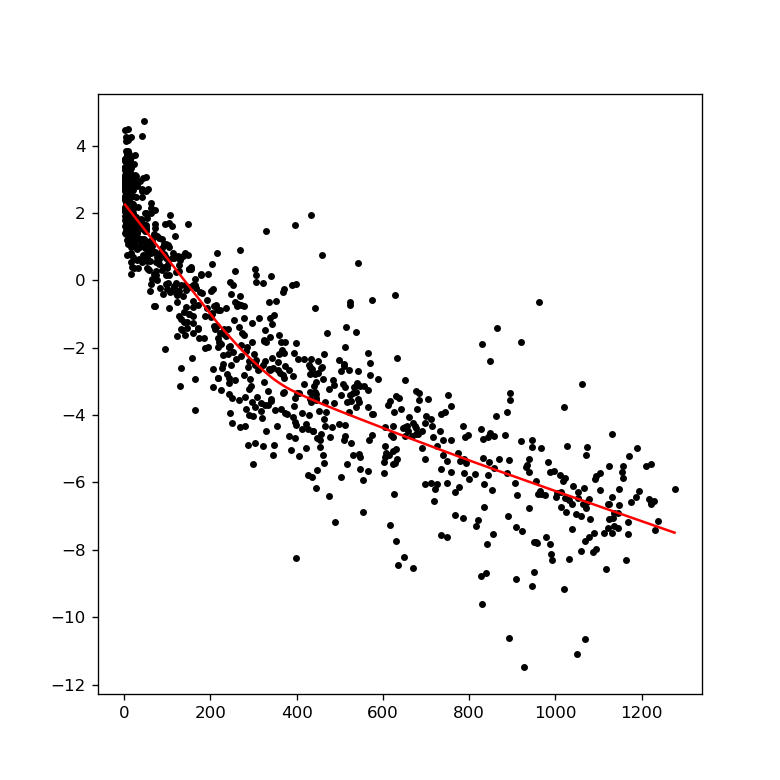

2.2752489000765785 -0.016014407969620587


<IPython.core.display.Javascript object>


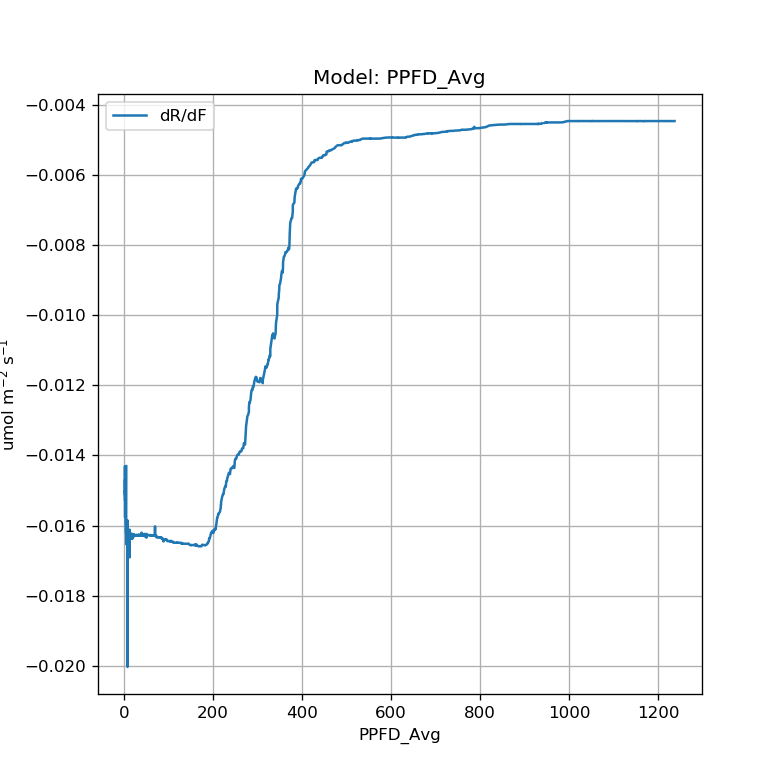

                        PPFD_Avg      Fill     dR/dF
datetime                                            
2016-07-24 02:30:00  4.669500     2.201106 -0.014305
2016-07-21 02:00:00  4.669833     2.201101 -0.016144
2016-07-28 02:00:00  4.671000     2.201082 -0.016451
2016-07-29 03:00:00  4.672000     2.201066 -0.016451
2016-07-29 03:30:00  4.672667     2.201055 -0.016066
2016-08-03 05:00:00  4.677000     2.200985 NaN      
2016-07-23 03:30:00  4.677000     2.200985 -0.016522
2016-07-17 03:00:00  4.680333     2.200930 -0.016093
2016-07-23 03:00:00  4.684333     2.200866 -0.016261
2016-07-21 04:00:00  4.705667     2.200519 -0.016236
2016-07-29 02:30:00  4.740000     2.199961 -0.016244
2016-07-31 01:30:00  4.772333     2.199436 -0.016322
2016-07-30 05:00:00  4.782500     2.199270 -0.016178
2016-07-21 03:30:00  4.789500     2.199157 -0.016245
2016-08-04 01:00:00  4.826000     2.198564 -0.016274
2016-07-21 01:30:00  4.838833     2.198355 -0.015855
2016-07-24 03:30:00  4.840833     2.198323 -0.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [159]:
import scipy.fftpack as fftpack
def F1(model,Data,Fill,var,Factor=None):
    Model = 'Model: '+model
    Data['Fill']=Fill[Model] 
    if var == 'fch4':
        Units = 'nmol m$^{-2}$ s$^{-1}$'
    else:
        Units = 'umol m$^{-2}$ s$^{-1}$'
    plt.figure(figsize=sizes)
    Test = Data[[var,'Fill']].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(Test[var],Test['Fill'])
# if Factor2 == None:
    if Factor == None:
        Factor = model
        Temp = Data[[Factor,'Fill']].sort_values(Factor).dropna(axis=0)
#         Temp['Fill']
        plt.scatter(Data[Factor],Data[var],label = 'Observations',s=10,c='black')
        plt.plot(Temp[Factor],Temp['Fill'],label = 'Modeled Flux\n'+\
                 'r${^2}$:'+str(np.round(r_value**2,2))+\
                '\nMSE: '+str(np.round(metrics.mean_squared_error(Test[var],Test['Fill']),2))+' '+Units,c='red')
        Temp3 = (Data.loc[Data[Factor]<=10])
        slope, intercept, r_value, p_value, std_err = stats.linregress(Temp3[Factor],Temp3['Fill'])
        print(intercept,slope)
#         print(Temp)
#         Temp = Temp.drop_duplicates(subset='PPFD_Avg')
        plt.figure(figsize=sizes)
        Temp['dR/dF'] = np.nan
        Temp['dR/dF'][:-1] = np.diff(Temp['Fill'])/np.diff(Temp[Factor])
        Temp[Temp['dR/dF']==0]=np.nan
        plt.plot(Temp[Factor][:-1],Temp['dR/dF'][:-1])
        print(Temp.loc[Temp['PPFD_Avg']>4.65])
        
    else:
        plt.scatter(Data[Factor[0]],Data[var],label = 'Observations',s=10,c='black')
        if len(Factor)>1:
            plt.scatter(Data[Factor[0]],Data['Fill'],c=Data[Factor[1]],
                cmap = plt.get_cmap('RdBu'),label = 'Modeled Flux\n'+'r${^2}$:'+str(np.round(r_value**2,2))+\
                '\nMSE: '+str(np.round(metrics.mean_squared_error(Test[var],Test['Fill']),2))+' '+Units)
            plt.colorbar()
        else:
            plt.scatter(Data[Factor[0]],Data['Fill'],c='red',s=10,
                label = 'Modeled Flux\n'+'r${^2}$:'+str(np.round(r_value**2,2))+\
                '\nMSE: '+str(np.round(metrics.mean_squared_error(Test[var],Test['Fill']),2))+' '+Units)
            
        
    plt.title(Model)
    plt.ylabel(Units)
    plt.xlabel(Factor)
    plt.grid()
    plt.legend()
    Fignum='3'
    plt.savefig('Fig'+Fignum+'.png')
# F1('PPFD_Avg',Data,fco2_fill,'fco2')
Model = 'PPFD_Avg'
F1(Model,Data,fco2_fill,'fco2')#,['PPFD_Avg','wind_speed'])
# Model = fch4_summary.loc[fch4_summary['Key']=='7_1','Model']
Model = 'PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass'
# F1(Model,Data,fco2_fill,'fco2',['PPFD_Avg'])
# print(fch4_fill.head())

<IPython.core.display.Javascript object>


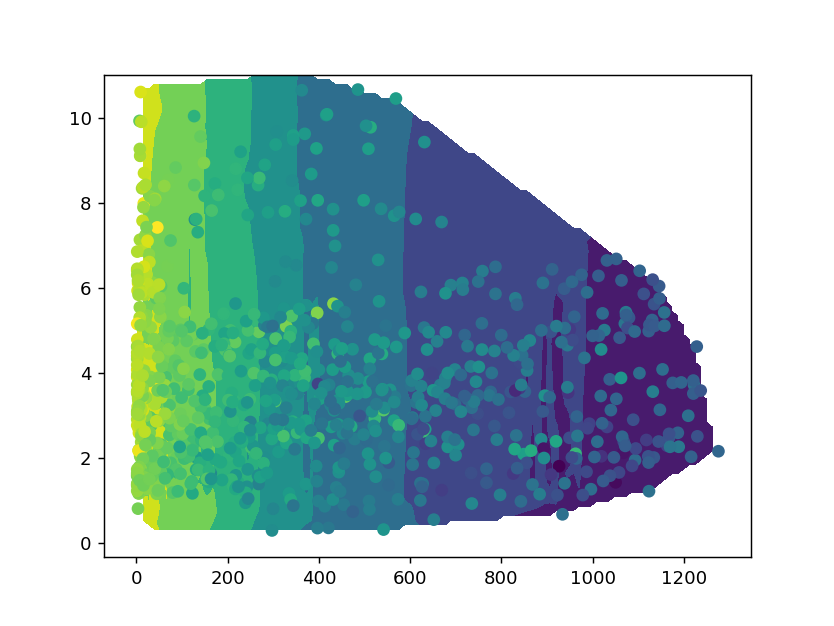

In [89]:

from scipy.interpolate import griddata
Model = 'PPFD_Avg+AirTC_Avg'
Data['Fill'] = fco2_fill['Model: '+Model]
Temp = Data[['PPFD_Avg','wind_speed','Fill']].dropna(axis=0)
x=Temp['PPFD_Avg'].values
y=Temp['wind_speed'].values
# z=Temp['Temp'].values
Response = Temp['Fill'].values
# print(Temp['Temp'].min(),Temp['Temp'])

xi = np.arange(x.min(),x.max(),(x.max()-x.min())/100)
yi = np.arange(y.min(),y.max(),(y.max()-y.min())/100)
# zi = np.arange(z.min(),z.max(),(z.max()-z.min())/100)
xi,yi = np.meshgrid(xi,yi)

ri = griddata((x,y),Response,(xi,yi),method='linear')
# print(xi.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
# print(ri)
ax.contourf(xi,yi,ri)#,np.arange(0,1.01,0.01))
ax.scatter(Data['PPFD_Avg'],Data['wind_speed'],c=Data['fco2'])


KeyError: 'Model: Sedge+VWC+Grass'

# Individual Model Performance

## Factor Effects

<IPython.core.display.Javascript object>


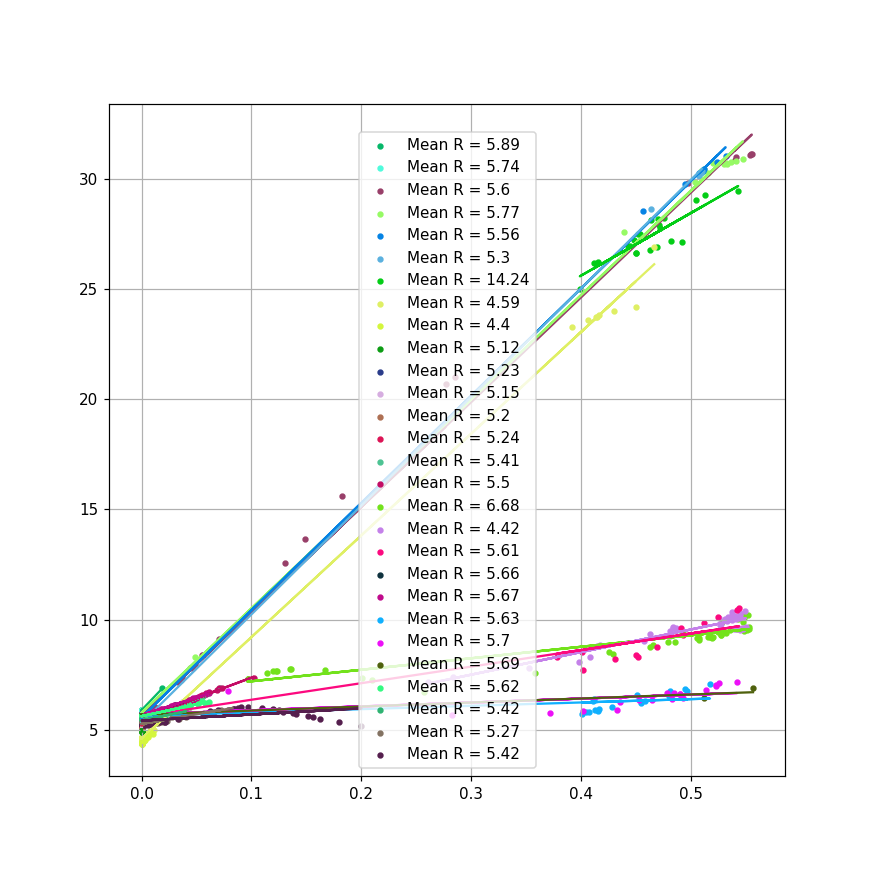

C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


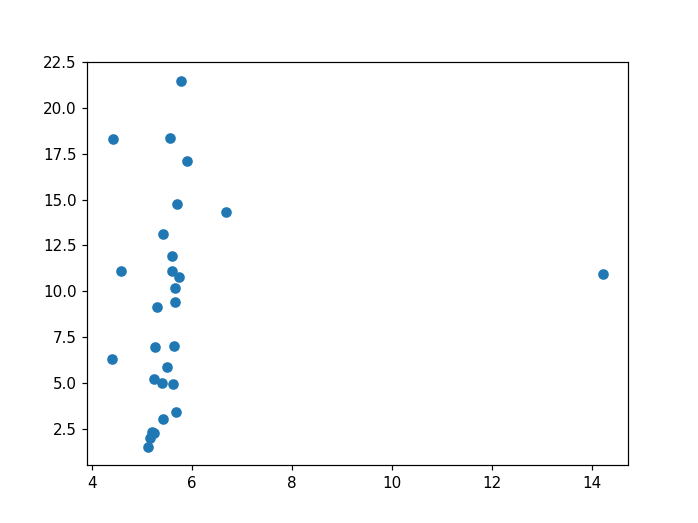

In [13]:
import datetime
from scipy.optimize import curve_fit
# print(Data)
Data['OffsetTime'] = (Data.index + datetime.timedelta(hours=12)).dayofyear
def Curve(x,a,b,c):
    return (b*x+c)
Daily = []
factor = []
thresh = 8
fig,ax = plt.subplots(figsize=(8,8))
for day in (Data['OffsetTime'].unique()):
    Temp = Data.loc[(Data['OffsetTime']==day)&(Data[Factor]<=200),[Factor,var,'Fill','AirTC_Avg','VPD']]
#     print(Temp)#,c='black')
    Temp = Temp.dropna()
    if Temp.shape[0]>=int(thresh):
        C=np.random.rand(3)
        popt, pcov = curve_fit(Curve, Temp[Factor].values, Temp['Fill'].values)
        ax.plot(Temp[Factor],Curve(Temp[Factor].values,*popt),c=C)
        ax.scatter(Temp[Factor],Temp['Fill'],s=10,c=C,
                label = 'Mean R = '+str(np.round(Curve(0,*popt),2)))
        Daily.append(Curve(0,*popt))
    else:
        Daily.append(np.nan)
    factor.append(Temp['AirTC_Avg'].median())
# plt.ylim(0,4.5)
# plt.xlim(-10,100)
plt.legend()
plt.grid()

plt.show()
fig,ax = plt.subplots()
ax.scatter(Daily,factor)

In [ ]:
# print(Data['Day'])